<a href="https://colab.research.google.com/github/oduoranto/Machine-Learning/blob/main/CalorieExpenditurePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
test_data = pd.read_csv('/content/test.csv')
train_data = pd.read_csv('/content/train.csv')
sample_data = pd.read_csv('/content/sample_submission.csv')

In [4]:
test_data.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [6]:
test_data.shape

(250000, 8)

In [8]:
sample_data.shape
sample_data.head()

,id,Calories
0,750000,88.283
1,750001,88.283
2,750002,88.283
3,750003,88.283
4,750004,88.283


In [14]:
print(train_data.shape)
train_data.head()

(750000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [15]:
test_data.isnull().sum()

,0
id,0
Sex,0
Age,0
Height,0
Weight,0
Duration,0
Heart_Rate,0
Body_Temp,0


In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


In [19]:
train_data.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


visualization of the data

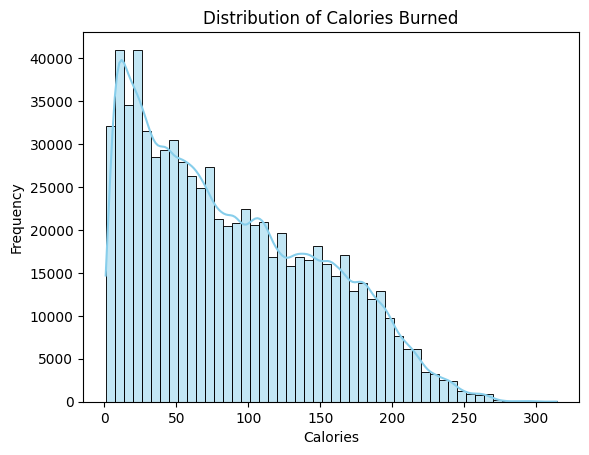

In [21]:
# --- 5. Distribution of Calories Burned ---
plt.figure()
sns.histplot(train_data['Calories'], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Calories Burned")
plt.xlabel("Calories")
plt.ylabel("Frequency")
plt.show()

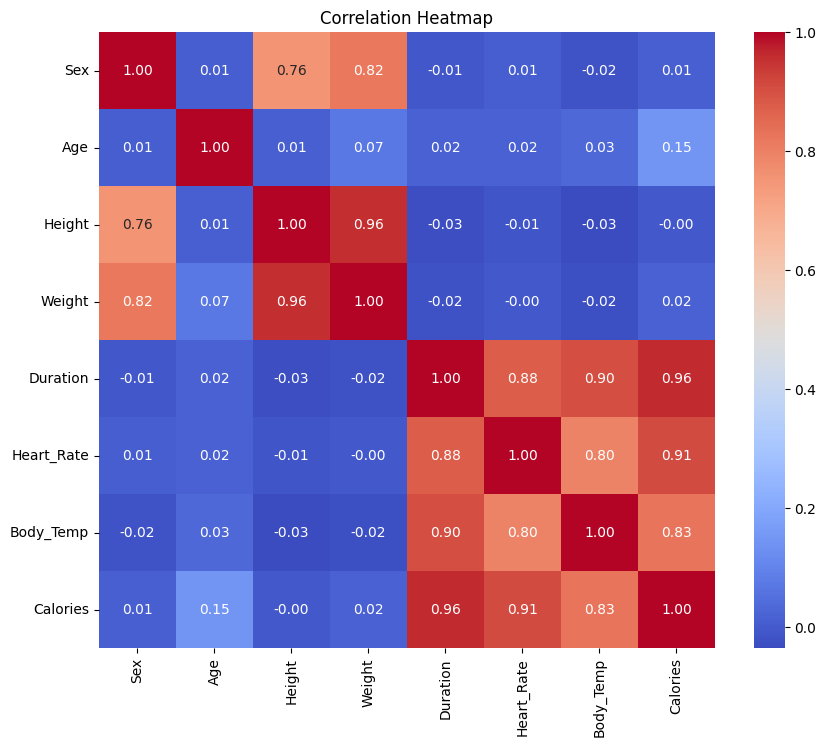

In [28]:
# Drop ID column for correlation matrix
df_encoded = train_data.copy()
df_encoded['Sex'] = df_encoded['Sex'].map({'female': 0, 'male': 1})
corr_matrix = df_encoded.drop(columns=["id"]).corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [30]:

# 2. Calculate BMI
df_encoded['Height_m'] = df_encoded['Height'] / 100
df_encoded['BMI'] = df_encoded['Weight'] / (df_encoded['Height_m'] ** 2)

# 3. Calories per minute (for insights)
df_encoded['Calories_per_min'] = df_encoded['Calories'] / df_encoded['Duration']

# 4. Log-transform the target (for RMSLE)
df_encoded['Calories_log'] = np.log1p(df_encoded['Calories'])

# 5. Drop unnecessary columns
df_encoded.drop(columns=['id', 'Height_m'], inplace=True)

# Preview result
df_encoded.head()


,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,Calories_per_min,Calories_log
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,5.769231,5.017280
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,4.250000,3.555348
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,4.142857,3.401197
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,5.600000,4.948760
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,5.840000,4.990433


In [33]:
# 2. Prepare features and target
X = df_encoded.drop(columns=['Calories', 'Calories_log', 'Calories_per_min'])
y = df_encoded['Calories_log']  # use log-transformed target

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train baseline model
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 5. Predict on test set
y_pred_log = model.predict(X_test)

# 6. Evaluate with RMSLE
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_log)))
print(f"✅ RMSLE on Test Set: {rmsle:.4f}")

[5.305417  4.168352  3.7386384 ... 3.5998478 3.6118836 5.1312537]
✅ RMSLE on Test Set: 0.0626


<ipython-input-34-d8c84dd35742>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
<ipython-input-34-d8c84dd35742>:11: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


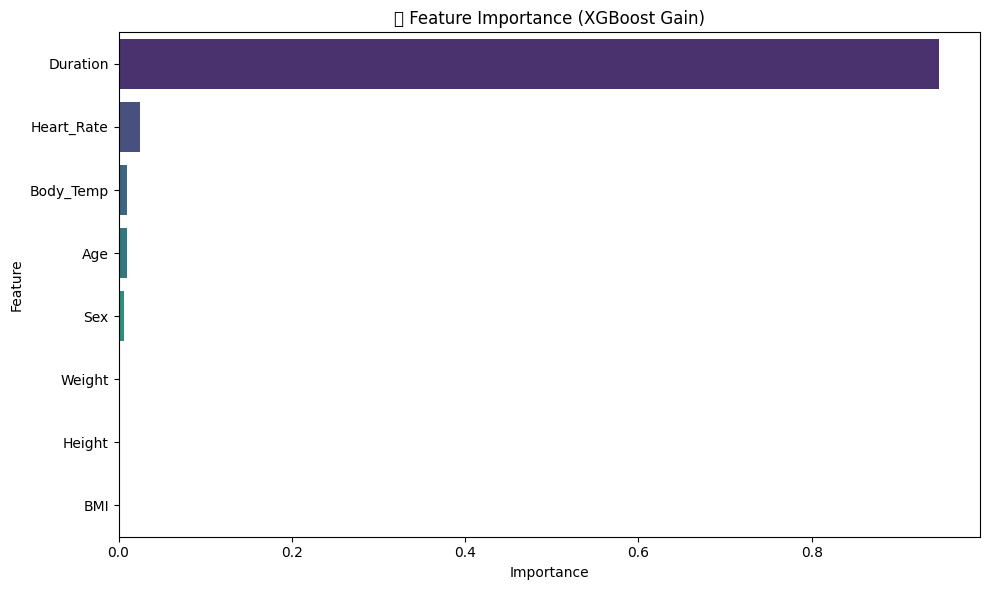

In [34]:
# Get feature importances
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('🔍 Feature Importance (XGBoost Gain)')
plt.tight_layout()
plt.show()

In [40]:
# Custom scorer (RMSLE)
def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize model
xgb = XGBRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=rmsle_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit search
grid_search.fit(X_train, y_train)

# Best result
best_model = grid_search.best_estimator_
print("✅ Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred_best_log = best_model.predict(X_test)
rmsle_best = rmsle_score(y_test, y_pred_best_log)
print(f"✅ Tuned Model RMSLE on Test Set: {rmsle_best:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
✅ Best Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}
✅ Tuned Model RMSLE on Test Set: 0.0602


In [41]:
import joblib

# Save the best model
joblib.dump(best_model, 'xgb_calories_model.pkl')
print("✅ Model saved as 'xgb_calories_model.pkl'")


✅ Model saved as 'xgb_calories_model.pkl'


In [42]:
# Example: Predict log calories for new data
new_data = X_test.iloc[0:5]  # You can replace this with real new inputs
pred_log = best_model.predict(new_data)
predicted_calories = np.expm1(pred_log)

print("🔮 Predicted Calories Burned:", predicted_calories)


🔮 Predicted Calories Burned: [197.0086    64.666534  40.66982  103.743355  51.56941 ]
